In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
raw_data = pd.read_csv("conversion_data.csv")

In [3]:
raw_data.head(2)

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0


In [6]:
raw_data.describe(include = 'all', percentiles=[0.5])
# There are four countries, 3 sources
# There might be outliers in the age group (max_age = 123)

,country,age,new_user,source,total_pages_visited,converted
count,316200,316200.000000,316200.000000,316200,316200.000000,316200.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,178092,NaN,NaN,155040,NaN,NaN
mean,NaN,30.569858,0.685465,NaN,4.872966,0.032258
std,NaN,8.271802,0.464331,NaN,3.341104,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
max,NaN,123.000000,1.000000,NaN,29.000000,1.000000


In [4]:
#check whether the dataset is balanced or not. 
raw_data.converted.value_counts(normalize=True)
#This is a very imbalanced dataset,with 96% not converted and 3% converted. 

0    0.967742
1    0.032258
Name: converted, dtype: float64

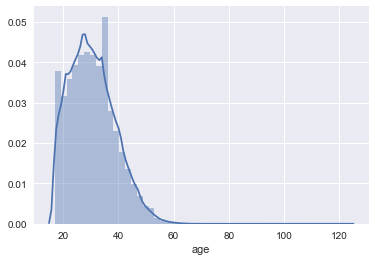

In [9]:
sns.distplot(raw_data['age'])
# There might be only a few outliers, I think it doesn't matter

In [ ]:
raw_data.drop()

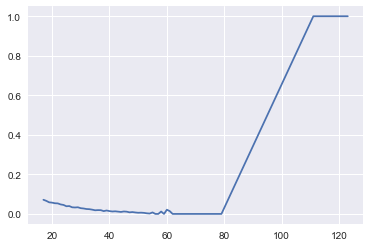

In [13]:
# plot the proportion of converted customers at different ages. 
proportion_ages = raw_data.groupby('age')[['converted']].mean()
plt.plot(proportion_ages['converted'])